<div style="background-color: #c1f2a5">


# PS4

# Part 1 

In Part 1 of this problem set, we will use the simplest type of a recurrent network, Elman network, to try to learn a simple language. 
## Instructions



Remember to do your problem set in Python 3. Fill in `#YOUR CODE HERE`.

Make sure: 
- that all plots are scaled in such a way that you can see what is going on (while still respecting specific plotting instructions) 
- that the general patterns are fairly represented.
- to label all x and y-axes, and to include a title.
    
    
**Note:** The ideas in this notebook draw heavily from the readings
<ol>
<li> Elman, J. L. (1990). Finding structure in time. <em>Cognitive Science, 14</em>, 179-211.
<li>McClelland, J., & Rumelhart, M. (1986). Past tenses of English verbs. In McClelland, J. and Rumelhart, D. (Eds.) <em>Parallel distributed processing: Explorations in the microstructure of cognition. Vol. 2: Applications</em> (pp. 216-271). Cambridge, MA: MIT Press.
</ol>
<br>
If you are confused about some of the ideas in this notebook or would like further clarification, we recommend having a look there.
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


## Introduction

One of the most successful (and controversial) applications of neural
        networks has been as models of human language. Specifically, contrary to the rules/symbols approach proposed by Chomsky, neural networks have been used to demonstrate that distributed representations can give rise to language learning. You will test whether a
simple neural network is capable of learning the rule underlying a
context-free language.

The language $a^nb^n$, being the set of all strings containing a
sequence of $a$'s followed by a sequence of $b$'s of the same length,
is a simple example of a language that can be generated by a
**context-free grammar** but not a **finite-state grammar** (because a finite state grammar cannot keep track of the number of times a string has occurred in the sentence). Human languages
exhibit similar long-range constraints -- for example, a plural noun
at the start of a sentence affects conjugation of a verb at the end,
regardless of what intervenes. Some criticisms of applications of
neural networks to human languages are based upon their apparent
reliance on local sequential structure, which makes them seem much
more similar to finite-state grammars than to context-free
grammars. In other words, simple neural networks will mostly use the most recent word to predict the next one. An interesting question to explore is thus whether a
recurrent neural network can learn to generalize a simple rule
characterizing a long-range dependency, such as the rule underlying
$a^nb^n$.

Recall that an **"Elman" network**, as discussed by Elman (1990), is a
recurrent network where the activation of the hidden units at the
previous timestep are used as input to the hidden units on the current
timestep. This type of network architecture allows the
network to learn about sequential dependencies in the input data. 
In this notebook, we will evaluate whether such a network can learn an $a^nb^n$
grammar. Here we formalize learning a grammar as being able to correctly
predict what the next item in a sequence should be given the
rules of the grammar. Therefore, the output node represents the
networks's prediction for what the next item in the sequence (the next
input) will be -- it outputs a $1$ if it thinks the current input will
be followed by an $a$, and outputs a $0$ if it thinks the current
input will be followed by a $b$.

## Q1. Data	[5pts, SOLO]
We will use the `abdata.npz` dataset for this problem. Make sure that the data file is in the same directory as your notebook while working on the problem set.

This dataset has two keys.
- The array with key `train_data` contains the sequence we will use to train our network.
- The array with key `test_data` contains the sequence we will use to evaluate the
network.

In both `train_data` and `test_data`, a $1$ represents an $a$ and a $0$ represents a $b$.

`train_data` was constructed by concatenating a randomly ordered
set of strings of the form $a^nb^n$, with $n$ ranging from 1 to 11.
The frequency of sequences for a given value of $n$ in the training set
are given by `np.ceil(50/n)`, thus making the frequencies inversely proportional to $n$.
The `np.ceil` function returns the smallest integer greater or equal to
its input. For example, `np.ceil(3)` is 3, but `np.ceil(3.1)` is
4 . 

`test_data` contains an ordered sequence of strings of the form
$a^nb^n$, with $n$ increasing from 1 to 18 over the length of the
string.

Take a look at the data! You can first print the variables. Next plot the first 100 values of train_data and the first 100 values of test_data in two subplots, as line plots with index numbers on the x axis and data values on the y axis. Upload your plot to gradescope as PS4_Q1.png


In [2]:
# load data
ab_data = np.load("abdata.npz")
ab_data.files

['train_data', 'test_data']

train_data
[1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
1156
test_data
[1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0
 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


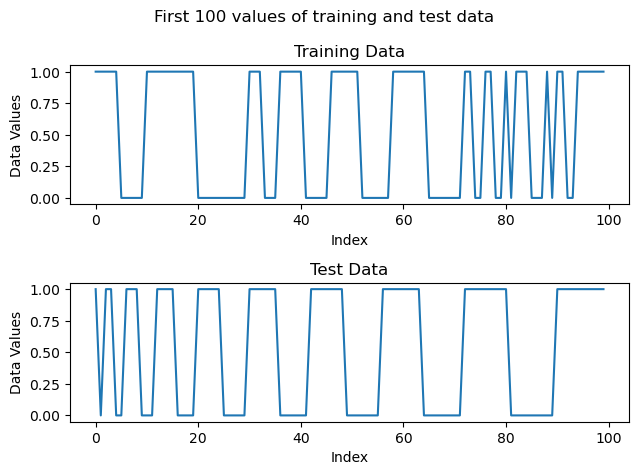

In [3]:
# look at train_data
print('train_data')
train_data = ab_data['train_data']
print(train_data[:30])
print(len(train_data))

## look at test_data
print('test_data')
test_data = ab_data['test_data']
print(test_data)

## plot the data
#YOUR CODE HERE
figure, axis = plt.subplots(2)

axis[0].plot(np.arange(0,100), train_data[0:100])
axis[1].plot(np.arange(0,100), test_data[0:100])

for i in np.arange(2):
    axis[i].set_ylabel('Data Values')
    axis[i].set_xlabel('Index')
    name = ['Training', 'Test']
    if i == 0:
        axis[i].set_title(f'{name[0]} Data')
    else:
        axis[i].set_title(f'{name[1]} Data')

figure.suptitle('First 100 values of training and test data')
figure.tight_layout()
figure.savefig('PS4_Q1.png')

## Q2. Input/output [3 pts, HELP]
In order to train your network, you will need both training *input* and
training *output*. 

That is, you need a sequence of inputs of the form
$a^nb^n$, and a corresponding sequence with the correct output for
each item in the input sequence.

For this problem we're going to use `train_data[:-1]` as the
input training sequence, and `train_data[1:]` as the output
training sequence.

Explain (1-2 sentences) in gradescope why these are appropriate input and output
sequences. If you're confused by what the sequences
`train_data[:-1]` and `train_data[1:]` look like,
try creating them in a cell and compare them to `train_data`.

In [4]:
train_data[:-1]

array([1, 1, 1, ..., 1, 1, 0])

In [5]:
train_data[1:]

array([1, 1, 1, ..., 1, 0, 0])

In [6]:
train_data

array([1, 1, 1, ..., 1, 0, 0])

## Elman network (provided)
We have provided you with a function, `train_Elman`, which takes four arguments:
- `input` &ndash; the training input sequence
- `output` &ndash; the training output sequence
- `num_hidden` &ndash; the number of hidden units
- `num_iters` &ndash; the number of training iterations: network needs to be trained on many iterations


`train_Elman` will:

1) create a network with one input node, the specified number of hidden units, and one output node


2) train the network on the training data for the specified number of iterations.


The network sees the
training data one input at a time (in our case, it sees a single $1$
or $0$ per time step).

In [7]:
def train_Elman(inputs, outputs, num_hidden, num_iters):
    """
    Initializes and trains an Elman network. For details see Elman (1990).

    Parameters
    ----------
    inputs : numpy array
        A one dimensional sequence of input values to the network

    outputs : numpy array
        A one-dimensional sequence of desired output values for each of the
        items in inputs

    num_hidden : int
        The number of hidden units to use in the network

    num_iters : int
        The number of training iterations to run the network for

    Returns
    -------
    net : dict
        Dictionary object containing the trained network weights for each layer. 
        Key 1 corresponds to the weights from the visibles to the hidden units,
        key 2 corresponds to the weights from the hiddens to the output units.

    NOTE: Poorly-Python-ported from trainElman.m, which in turn was adapted from
    code from http://www.cs.cmu.edu/afs/cs/academic/class/15782-f06/matlab/
    recurrent/ which in turn was adapted from Elman (1990) :-)
    """
    np.random.seed(seed=1)

    # Parameters
    # increment to the derivative of the transfer function (Fahlman's trick)
    DerivIncr = 0.2
    Momentum  = 0.05
    LearnRate = 0.001

    num_input  = 1
    num_output = 1
    num_train  = inputs.shape[0]

    if inputs.ndim == 2:
        num_input  = inputs.shape[0]
        num_output = outputs.shape[0]
        num_train  = inputs.shape[1]

    if not all([outputs.ndim == inputs.ndim,
               inputs.shape[0] == outputs.shape[0]]):
        raise ValueError('unequal number of input and output examples')

    # create a dictionary to hold the network weights
    net = {}
    net[1] = np.random.rand(num_hidden, num_input + num_hidden + 1) - 0.5
    net[2] = np.random.rand(num_output, num_hidden + 1) - 0.5

    # the context layer
    # zeros because it is not active when the network starts
    Result1 = np.zeros((num_hidden, num_train))

    # the row of ones is the bias
    Inputs = np.vstack((inputs, np.ones(num_train)))
    Desired = outputs

    delta_w1 = 0.
    delta_w2 = 0.

    # Training
    for ii in range(num_iters):
        # Recurrent state
        # includes current inputs, as well as the output of the hidden layer
        # from the previous time step
        Input1 = np.vstack((Inputs, np.hstack([np.zeros((num_hidden,1)),  Result1[:,:-1]])))

        # Forward propagate activations
        # input --> hidden
        NetIn1 = np.dot(net[1], Input1)
        Result1 = np.tanh(NetIn1)

        # Hidden --> output
        # we again add a row of ones for bias
        Input2 = np.vstack((Result1, np.ones(num_train)))
        NetIn2 = np.dot(net[2], Input2)
        Result2 = np.tanh(NetIn2)

        # Backprop errors
        # output --> hidden
        Result2Error = Result2 - Desired
        In2Error = Result2Error * (DerivIncr + np.cosh(NetIn2)**(-2))

        # hidden --> input
        Result1Error = np.dot(net[2].T, In2Error)
        In1Error = Result1Error[:-1, :] * (DerivIncr + np.cosh(NetIn1)**(-2))

        # Calculate weight updates
        dw2 = np.dot(In2Error, Input2.T)
        dw1 = np.dot(In1Error, Input1.T)

        delta_w2 = -LearnRate * dw2 + Momentum * delta_w2
        delta_w1 = -LearnRate * dw1 + Momentum * delta_w1

        net[2] = net[2] + delta_w2
        net[1] = net[1] + delta_w1
    return net



## Q3 - learn $a^nb^n$ language [5 pts, HELP]
Complete the function `anbn_learner` below to train an "Elman"
network with two hidden units using the provided function `train_Elman` (remember
to use the input **train_data[:-1]** and output **train_data[1:]** sequences from Q2).



Train the network for *100 iterations*, and return the final output of the network.
We provide test cases. If you got the function right, the following cell should print "Success". Otherwise, it will give you an error message that will help with debugging.

Copy your code into gradescope.

In [8]:
def anbn_learner(train_data):
    """
    Creates an "Elman" neural network with two hidden units and trains it
    on the provided data.

    Parameters
    ----------
    train_data: numpy array of shape (n,)
        the data on which to train the Elman network

    Returns
    -------
    net: dictionary with 2 keys
        a dictionary containing the weights of the network. Valid keys are 1 and 2. 
        key 1 is for the weights between the input and the hidden units, and 
        key 2 is for the weights between the hidden units and the output units.
    """
    # YOUR CODE HERE
    input_D = train_data[:-1]
    output_D = train_data[1:]
    
    hidden_units = 2
    iters = 100
    
    return train_Elman(input_D, output_D, hidden_units, iters)
    

In [9]:
"""Check that anbn_learner returns the correct output"""
from numpy.testing import assert_array_equal
from nose.tools import assert_equal, assert_almost_equal 

# check that abdata hasn't been modified
ab = np.load("abdata.npz")
assert_array_equal(test_data, ab['test_data'], "test_data array has changed")
assert_array_equal(train_data, ab['train_data'], "train_data array has changed")

# generate test data
traindata = np.zeros(20)
traindata[10:] = 1.

net = anbn_learner(traindata)

# check that net has the correct shape and type
assert_equal(type(net), dict, "net should be a dict of network weights")
assert_equal(len(net), 2, "incorrect number of layers in net")
assert_equal(list(net.keys()), [1,2], "keys for net should be 1 and 2")

# check the dimensions of the weight matrices
assert_equal(net[1].shape, (2,4), "invalid network weights for the input -> hidden layer")
assert_equal(net[2].shape, (1,3), "invalid network weights for the hidden -> output layer")

# check the weight matrix sums to the correct value on testdata
assert_almost_equal(np.sum(net[1]), -1.9326, places=4, msg="weights for input --> hidden layer are incorrect")
assert_almost_equal(np.sum(net[2]), 0.01825, places=4, msg="weights for hidden --> output layer are incorrect")
print("Success!")

Success!


## Q4 - checking the trained network [5 pts, SOLO]
Once the network is trained (*your anbn_learner function should pass the test case in the previous cell)*, you can test it on a new set of sequences
and evaluate its predictions to see how well it has learned the target
 grammar. To generate predictions from the trained network, we use the provided function `predict_Elman`. 
 
Use your `anbn_learner` function on `train_data` to train a network, then use your trained network (by passing it as the first input to `predict_Elman` function) to generate output predictions for each of the input elements in `test_data`

A) The `predict_Elman` function returns an array of predicted values with the same dimensions as the input. Plot your first 100 predictions (sequence index number on x axis, predicted values on y axis) and upload the figure to gradescope as PS4_Q4.png.

B) Look back at your plot of the test data in Q1 - what do you think of the network's predictions? Do your predictions approximate the testing data? In a few sentences, explain why you think they do, or why you think they do not, by referring to the mechanisms of recurrent networks and the nature of the data.

In [10]:

def predict_Elman(net, inputs):
    """
    Uses the Elman network parameterized by the weights in net to generate
    predictions for the elements in inputs.

    Parameters
    ----------
    net : dict
        Dictionary object containing the trained network weights and
        recurrent connections as produced by train_Elman. Key 1 corresponds 
        to the weights from the visibles to the hidden units, key 2 
        corresponds to the weights from the hiddens to the output units.

    inputs : numpy array
        A one dimensional sequence of input values to the network

    Returns
    -------
    outputs : numpy array
        An array containing the predictions generated by the Elman network for the
        items in inputs.
        
    NOTE: Poorly-Python-ported from predictElman.m, which in turn was adapted from
    code from http://www.cs.cmu.edu/afs/cs/academic/class/15782-f06/matlab/
    recurrent/ which in turn was adapted from Elman (1990) :-)
    """
    num_output = 1
    num_hidden = net[1].shape[0]
    num_train  = inputs.shape[0]

    if inputs.ndim == 2:
        num_train = inputs.shape[1]

    Inputs = np.vstack((inputs, np.ones([1, num_train])))
    Result1 = np.zeros([num_hidden, 1])

    outputs = np.zeros(num_train)

    for i in range(num_train):
        Input1 = np.append(Inputs[:, i], Result1)
        NetIn1 = np.dot(net[1], Input1)
        Result1 = np.tanh(NetIn1)

        Input2 = np.append(Result1, np.ones((1, 1)))
        NetIn2 = np.dot(net[2], Input2)
        outputs[i] = np.tanh(NetIn2)
    return outputs


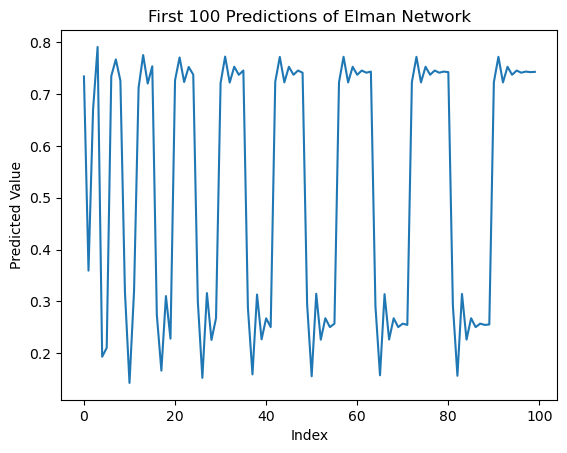

In [11]:
## YOUR CODE HERE
network = anbn_learner(train_data)
pred_vals = predict_Elman(network, test_data)

figure, axis = plt.subplots()

axis.plot(np.arange(100), pred_vals[:100])
axis.set_xlabel('Index')
axis.set_ylabel('Predicted Value')
axis.set_title('First 100 Predictions of Elman Network')

figure.savefig('PS4_Q4.png')


## Q5 - Quantifying the model performance [2pts, HELP]

How well does the network do at predicting the next letter? Has it learned the language? Let's look more carefully.

To quantify how well the network performs we are going to look at how much the predicted sequence deviates from expectations. The squared error (SE) for a prediction $p_i$ in the prediction vector ${\bf p}$
compared to a target value ${y_i}$ in the target vector ${\bf y}$ is

\begin{equation}
SE_i = (p_i-y_i)^2
\end{equation}

That is, the squared error is just the squared difference between the
predicted and target value.
	
Complete the function `squared_error`, which takes in an array of test data and an array of
predictions. The function should return an error array **with the same number of elements as the test data**, containing the SE for each of the predictions of the network compared against the corresponding value in `test_data`. 

Remember that the predictions refer to the _next_ item in the sequence
(e.g.  `predictions[0]` should be compared to `test_data[1]`, etc.). You should append an $a$ (coded as a $1$) to the end of your test data to equate the array sizes (describing the start of a new sequence of $a^nb^n$). If the reason for appending $a$ is unclear, think about whether the test data would follow the rules of the grammar if you were to append $b$ instead.

We have provided test cases again in the cell below. If your function is right, it should print success. Otherwise, it will give you an error with feedback.

Copy your function into gradescope.

In [12]:
def squared_error(predictions, test_data):
    """
    Uses equation 1 to compute the SE for each of the predictions made 
    by the network.

    Parameters
    ----------
    predictions: numpy array of shape (n,)
        an array of predictions from the Elman network
    
    test_data: numpy array of shape (n,) 
        the array of test data from which predictions were generated

    Returns
    -------
    se_vector: numpy array of shape (n,)
        an array containing the SE for each of items in predictions 
    """
    # YOUR CODE HERE
    test = test_data.copy()
    test = np.append(test, 1)
    
    return (predictions - test[1:]) ** 2



In [13]:
"""Check that squared_error returns the correct output"""
from nose.tools import assert_equal

# generate test data
pred = np.array([1, 0, 1])
test = np.array([0, 1, 0])
se = squared_error(pred, test)

# check that squared_error returns the correct output for testdata
#assert_equal(se.dtype, np.float64, "squared_error should return an array of floats")
assert_equal(se.shape, (3,), "squared_error returned an array of the incorrect size on the validate testdata")
assert_array_equal(se, np.zeros(3), "squared_error should return all zeros on the validate testdata")

# check that squared_error compares the correct elements
pred = np.zeros(1)
test = np.zeros(1)
se = squared_error(pred, test)
assert_equal(se, np.ones(1), "squared_error([0],[0]) should have returned a 1 (did you remember to append an a to testdata?")

print("Success!")

Success!


In [14]:
#YOUR OWN TESTS HERE

---

## Q6 [5 pts, SOLO]
Train the network on the `train_data`, then apply it to the `test_data`: try to predict test data using the weights of the trained network. Measure the resulting squared error.

Use matplotlib to plot a bar graph of the squared error for each training example. You should have the sequence iteration number on the x axis, and the error values on y axis. Don't forget to provide a title and labels your $x$ and $y$ axes!

If you have difficulty interpreting this graph, you may want to
examine a few of the values in `test_data`, `predictions`, and your `mse_vector` to see how they are related.
Upload your figure PS4_Q6.png to gradescope.

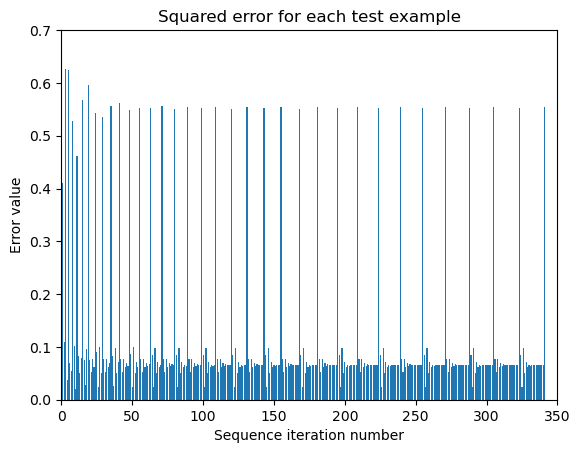

In [15]:

# YOUR CODE HERE
net = anbn_learner(train_data)
predictions = predict_Elman(net, test_data)
se_vector = squared_error(predictions, test_data)


# create the figure
fig, axis = plt.subplots()
axis.set_xlabel('Sequence iteration number')
axis.set_ylabel('Error value')
axis.set_title('Squared error for each test example')
axis.set_xlim([0.0, 350.0]), axis.set_ylim([0.0,.7])

# YOUR CODE HERE
axis.bar(np.arange(len(se_vector)),se_vector)

fig.savefig('PS4_Q6.png')

## Q7 [5pts, SOLO]

To get a better idea of what is going on, let's have a look at the specific values in `test_data` where the prediction error spikes. Use the provided code below and look at its output. 

At which points in `test_data` do the large errors occur? In 1-2 sentences, explain which parts of the data the network is predicting ok, and which parts it's not predicting well. Answer in gradescope.

In [16]:
# prints the 3 values preceding and 2 values following the spot where 
# the prediction error >= 0.5
error_spike_idxs = np.argwhere(se_vector >= 0.5) + 1
error_spike_idxs = error_spike_idxs[:-1]

for i in error_spike_idxs:
    print('3 values preceding MSE spike: {}\tValue at MSE spike: {}'
          '\t\t2 values following MSE spike: {}'\
          .format(test_data[i[0]-3:i[0]], test_data[i[0]], test_data[i[0]+1:i[0]+3]))

3 values preceding MSE spike: []	Value at MSE spike: 0		2 values following MSE spike: [1 1]
3 values preceding MSE spike: [0 1 1]	Value at MSE spike: 0		2 values following MSE spike: [0 1]
3 values preceding MSE spike: [1 0 0]	Value at MSE spike: 1		2 values following MSE spike: [1 1]
3 values preceding MSE spike: [1 1 1]	Value at MSE spike: 0		2 values following MSE spike: [0 0]
3 values preceding MSE spike: [1 1 1]	Value at MSE spike: 0		2 values following MSE spike: [0 0]
3 values preceding MSE spike: [0 0 0]	Value at MSE spike: 1		2 values following MSE spike: [1 1]
3 values preceding MSE spike: [1 1 1]	Value at MSE spike: 0		2 values following MSE spike: [0 0]
3 values preceding MSE spike: [0 0 0]	Value at MSE spike: 1		2 values following MSE spike: [1 1]
3 values preceding MSE spike: [1 1 1]	Value at MSE spike: 0		2 values following MSE spike: [0 0]
3 values preceding MSE spike: [0 0 0]	Value at MSE spike: 1		2 values following MSE spike: [1 1]
3 values preceding MSE spike: [1 1 



## Q8.1. Conclusions [5pts, SOLO]

A) Earlier we said that we can evaluate whether the network has learned
the grammar by looking at the predictions it makes. If the network has
learned the $a^nb^n$ grammar, in what cases should it make correct
predictions? When should it make incorrect predictions?

B) Do your predictions about when the network should make correct/incorrect predictions if it has learned the $a^nb^n$ grammar match the the times when the network makes large errors, as identified in Q7? Did the network learn the $a^nb^n$ language?

Answer A and B in gradescope in 1-3 sentences each.


## Q8.2. Conclusion [5pts, SOLO]

A) At what level of the Chomsky hierarchy is the $a^nb^n$ grammar? How does this compare to the level of most natural languages? Specifically, what level of Chomsky's hierarchy describes most of the natural languages, and are these levels higher relative to that of $a^nb^n$?

B) Use this to explore the implications of your results from Q7 and Q8.1 for using the Elman network to model the relationships present in human language. Is the Elman network likely to be sufficient to capture human language satisfactorily?

Answer A and B in gradescope in 1-3 sentences each.

---

<div style="background-color: #c1f2a5">


# Part 2

In this part of the problem set, we will play the number game (Tenenbaum, 2000) that we talked about in the statistical learning lecture. We have a mysterious device that accepts some numbers between 1 and 100 but not others. We will use Bayes' rule to figure out what rule our device might follow and which numbers are likely to be accepted, given some data about the numbers that the device has accepted.
    
## Instructions



Remember to do your problem set in Python 3. Fill in `#YOUR CODE HERE`.

Make sure: 
- that all plots are scaled in such a way that you can see what is going on (while still respecting specific plotting instructions) 
- that the general patterns are fairly represented.
- to label all x- and y-axes and to include a title.
    
</div>

## Introduction
In this problem set, consider the following hypotheses for all integers from 1 to 100:
- H0: Even numbers from 2 to 100 (2, 4, 6, ..., 100)
- H1: Odd numbers from 1 to 99 (1, 3, 5, ..., 99)
- H2: Square numbers (1, 4, 9, ..., 100)
- H3: Prime numbers (2, 3, 5, ..., 97)
- H4: Multiples of 5 (5, 10, 15, ..., 100)
- H5: Multiples of 10 (10, 20, 30, ..., 100)
- H6: Powers of 2 (2, 4, 8, ..., 64)
- H7: All numbers (1, 2, 3, ..., 100)

Unless otherwise specified (in Q13), each hypothesis is assumed to be **equally likely to be true** (P(H0) = ... = P(H7) = 1/8) and can be represented as a NumPy array containing acceptable numbers.

## Q9. Data	[5pts, SOLO]

To begin, let's create a NumPy array for each of our 8 hypotheses and store the 8 arrays in a list. 

Then in 8 subplots (1 per hypothesis), plot whether or not the hypothesis has each number from 1 to 100 (x-axis) in it (1 if yes, 0 if not, y-axis). You **MUST** follow the plotting instructions below to get full credit:

- Use (16, 10) as your global figure size (`figsize=(16, 10)`)
- Arrange 8 subplots in a 4 (rows) $\times$ 2 (columns) grid
- Title each subplot using the corresponding hypothesis label (i.e., "H1", "H2", etc.)
- Label all x- and y-axes in the subplots and title your global figure
- Use `axes[i].bar()` instead of `axes[i].plot()`

> **Tip**: add `plt.tight_layout()` in the end before saving your plot to avoid overlapping between subplots.

Finally, upload your figure in Gradescope as `PS4_Q9.png`.

In [17]:
def is_prime(n):
    """Determine if given number if prime"""
    status = True
    if n < 2:
        status = False
    else:
        for i in range(2, n):
            if n % i == 0:
                status = False
    return status

In [18]:
# Create 8 hypotheses
H0 = np.arange(2, 101, 2)  # Even numbers from 2 to 100
H1 = np.arange(1, 100, 2)  # Odd numbers from 1 to 00
H2 = np.arange(1, 11) ** 2  # Square numbers
H3 = np.array([i for i in range(101) if is_prime(i)])  # Prime numbers
H4 = np.arange(5, 101, 5)  # Multiples of 5
H5 = np.arange(10, 101, 10)  # Multiples of 10
H6 = 2 ** np.arange(1, 7)  # Powers of 2
H7 = np.arange(1, 101)  # All numbers
H = [H0, H1, H2, H3, H4, H5, H6, H7]

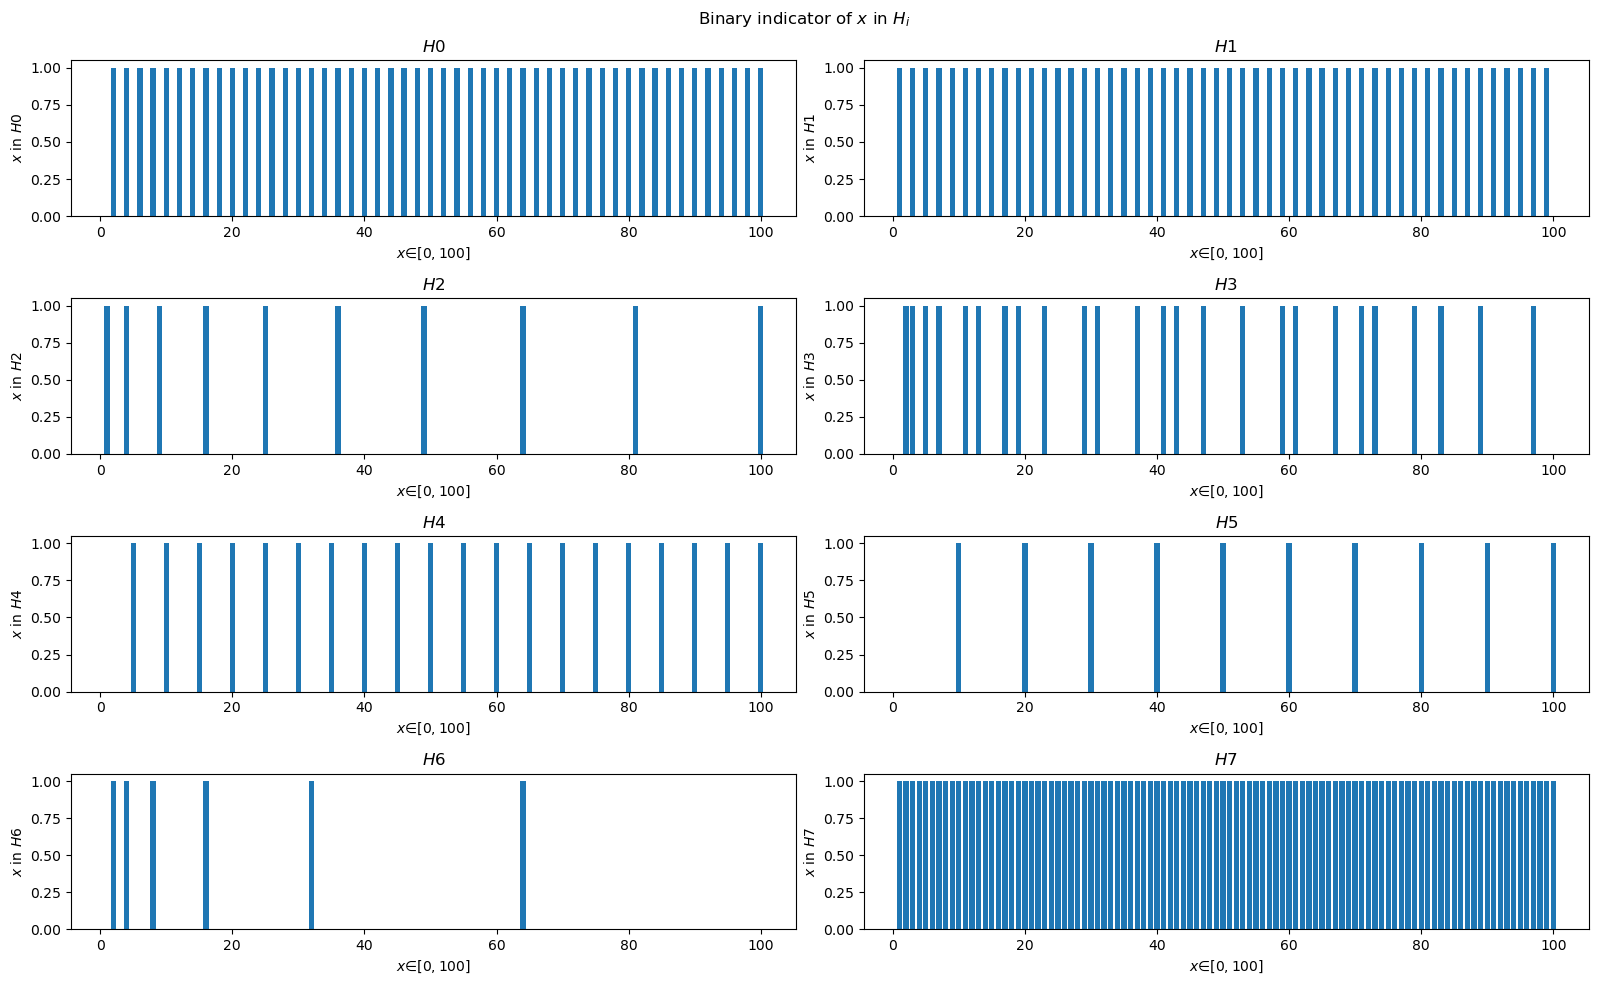

In [19]:
# YOUR CODE HERE
figure, axis = plt.subplots(nrows=4, ncols=2, figsize=(16,10))

for i, ax in enumerate(figure.axes):
    contains = []
    for j in np.arange(1,101):
        if j in H[i]:
            contains.append(1)
        else:
            contains.append(0)
    ax.bar(np.arange(1,101), contains)
    ax.set_title(f"$H{i}$")
    ax.set_xlabel("$x∈[0,100]$")
    ax.set_ylabel(f"$x$ in $H{i}$")
    
figure.suptitle("Binary indicator of $x$ in $H_i$")
figure.tight_layout()
figure.savefig("PS4_Q9.png")

## Q10. Likelihood [10 pts HELP]

In this question, you will be computing the likelihood of data under a given hypothesis. Your data will be represented as an array (e.g., [3, 19, 63]).

To do so, write a function called `compute_likelihood` that takes a NumPy array (each number is a **unique** integer between 1 and 100) and a hypothesis (H0-H7, as specified in Q9) as inputs and returns 1) an array containing the likelihood of each number independently (e.g., the likelihoods of 3, 19, and 63 separately) as well as 2) the likelihood of the entire array (e.g., the likelihood of [3, 19, 63]). 

Please think back on the **size principle** when calculating likelihoods and assume that each number allowed by a particular hypothesis is equally likely. 

1. In Gradescope, write down what likelihood each of the 8 hypotheses assigns to a number accepted by it and a number that is not accepted.

2. In 8 subplots (1 per hypothesis), plot the likelihood of each individual number between 1 and 100 under that hypothesis. You **MUST** follow the plotting instructions below to get full credit:

- Use (16, 10) as your global figure size (`figsize=(16, 10)`)
- Arrange 8 subplots in a 4 (rows) $\times$ 2 (columns) grid
- Title each subplot using the corresponding hypothesis label (i.e., "H1", "H2", etc.)
- Label all x- and y-axes in the subplots and title your global figure
- Use `[0, .2]` as the y-axis limit in each subplot
- Use `axes[i].bar()` instead of `axes[i].plot()`

> **Tip**: add `plt.tight_layout()` in the end before saving your plot to avoid overlapping between subplots.

Finally, upload your figure in Gradescope as `PS4_Q10.png`.

In [20]:
def compute_likelihood(hyp, data=np.arange(1,101)):
    independent = []
    for i in data:
        if i in hyp:
            independent.append(1/len(hyp))
        else:
            independent.append(0)
            
    if len(independent) != 0:
        entire = np.prod(independent)
    elif len(independent) == 0 and len(data) == 0:
        entire = 1
    else:
        entire = 0
    
    return independent, entire

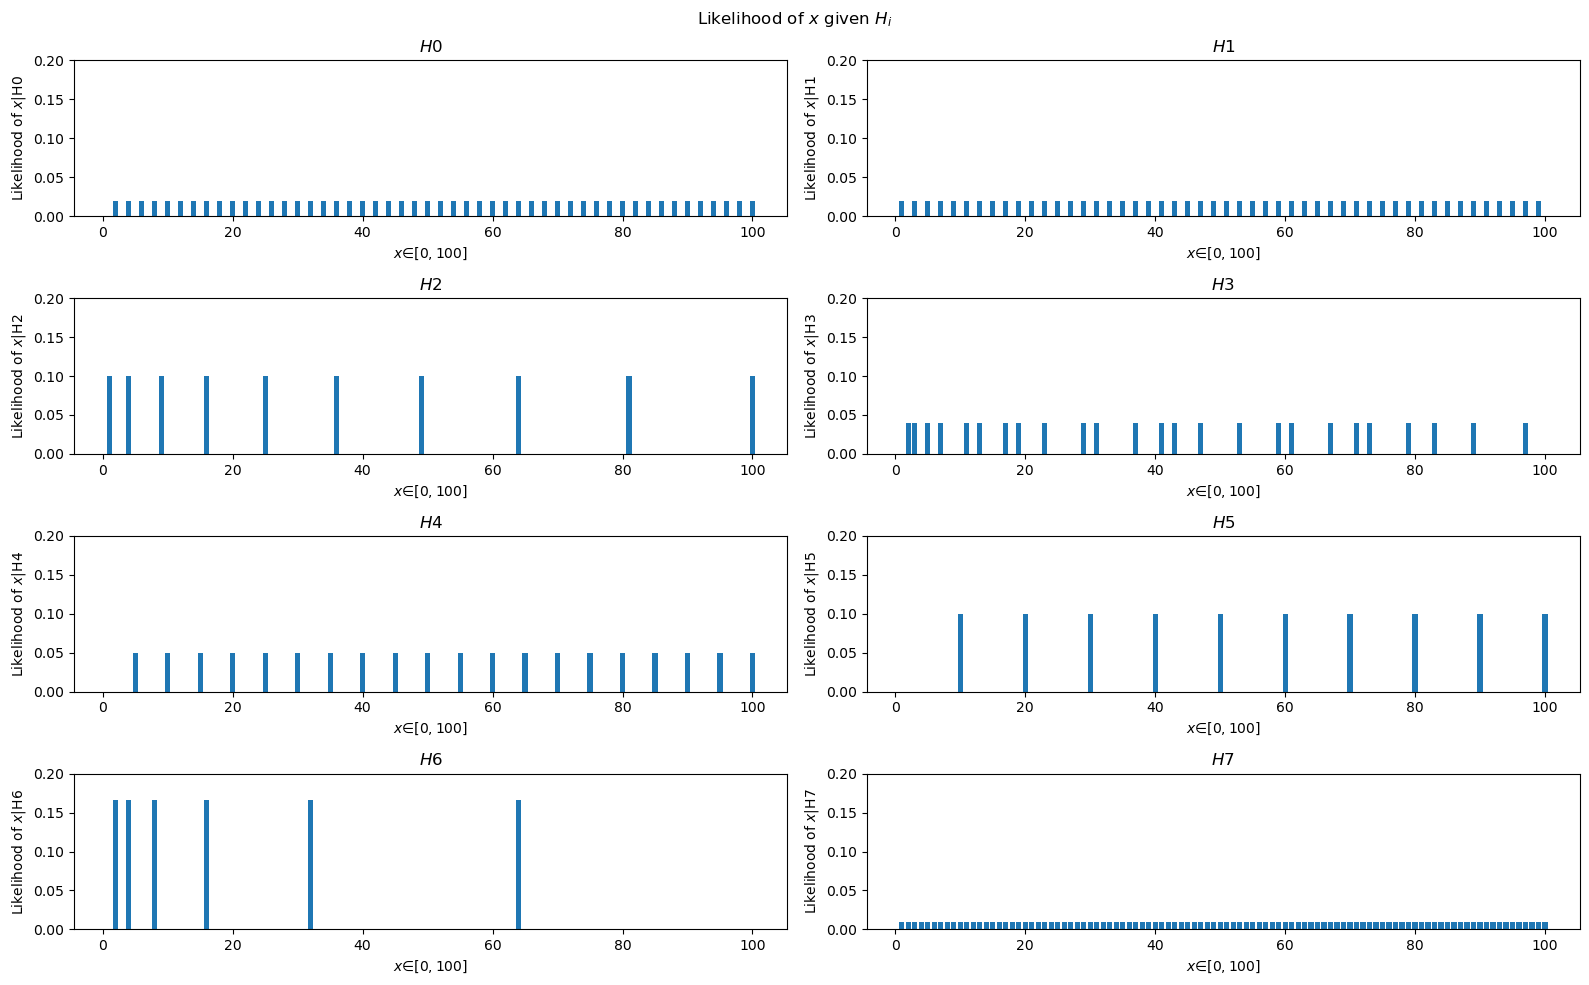

In [21]:
# YOUR CODE HERE
figure, axis = plt.subplots(nrows=4, ncols=2, figsize=(16,10))

for i, ax in enumerate(figure.axes):
    ind, ent = compute_likelihood(H[i])
    ax.bar(np.arange(1,101), ind)
    ax.set_title(f"$H{i}$")
    ax.set_xlabel("$x∈[0,100]$")
    ax.set_ylim([0,0.2])
    ax.set_ylabel(f"Likelihood of $x$|H{i}")
    
figure.suptitle("Likelihood of $x$ given $H_i$")
figure.tight_layout()

figure.savefig("PS4_Q10.png")

In [22]:
for h in H:
    print(len(h))

50
50
10
25
20
10
6
100


## Q11 - Bayes' rule [10 pts SOLO]

Now let's calculate the posterior probability of each hypothesis in light of data. Below are 8 datasets you'll be working with:

- (a) No data 
- (b) 50
- (c) 53
- (d) 50, 53 
- (e) 16
- (f) 10, 20
- (g) 2, 4, 8
- (h) 2, 4, 8, 10

As mentioned in the very beginning, let's assume that each of our 8 hypotheses is equally likely prior to seeing data and that, under each hypothesis, each number allowed by it is also equally likely (the "size principle likelihood").

Write a function called `compute_posterior` that computes the posterior probability of each hypothesis given a dataset. Note that the 8 probabilities should sum to 1. Please check to make sure that's the case!

Your function should take three arguments &mdash; a dataset (a NumPy array), a set of hypotheses (a list), and the prior probabilities of the hypotheses (a NumPy array) &mdash; and return an array containing the posterior probability of each hypothesis.

In 8 subplots (1 per dataset), plot the posterior probability of each hypothesis. You **MUST** follow the plotting instructions below to get full credit:

- Use (16, 10) as your global figure size (`figsize=(16, 10)`)
- Arrange 8 subplots in a 4 (rows) $\times$ 2 (columns) grid
- Title each subplot using the corresponding dataset label (i.e., "D1", "D2", etc.)
- Label all x- and y-axes in the subplots and title your global figure
- Use `axes[i].bar()` instead of `axes[i].plot()`

> **Tip**: add `plt.tight_layout()` in the end before saving your plot to avoid overlapping between subplots.


Finally, upload your figure in Gradescope as `PS3_Q11.png`.

In [23]:
# Generate the 8 datasets
DataSets = []

D0 = np.empty(0)
DataSets.append(D0)

D1 = np.array([50])
DataSets.append(D1)

D2 = np.array([53])
DataSets.append(D2)

D3 = np.array([50, 53])
DataSets.append(D3)

D4 = np.array([16])
DataSets.append(D4)

D5 = np.array([10, 20])
DataSets.append(D5)

D6 = np.array([2, 4, 8])
DataSets.append(D6)

D7 = np.array([2, 4, 8, 10])
DataSets.append(D7)

In [24]:
def compute_posterior(data, hyp, prior):
    
    norm = 0
    likelihood = []
    for p, h in zip(prior, hyp):
        arr, like = compute_likelihood(h, data)
        norm += like * p
        likelihood.append(like)
        
    posterior = []
    for p, l in zip(prior, likelihood):
        posterior.append((l*p)/norm)
        
    return posterior

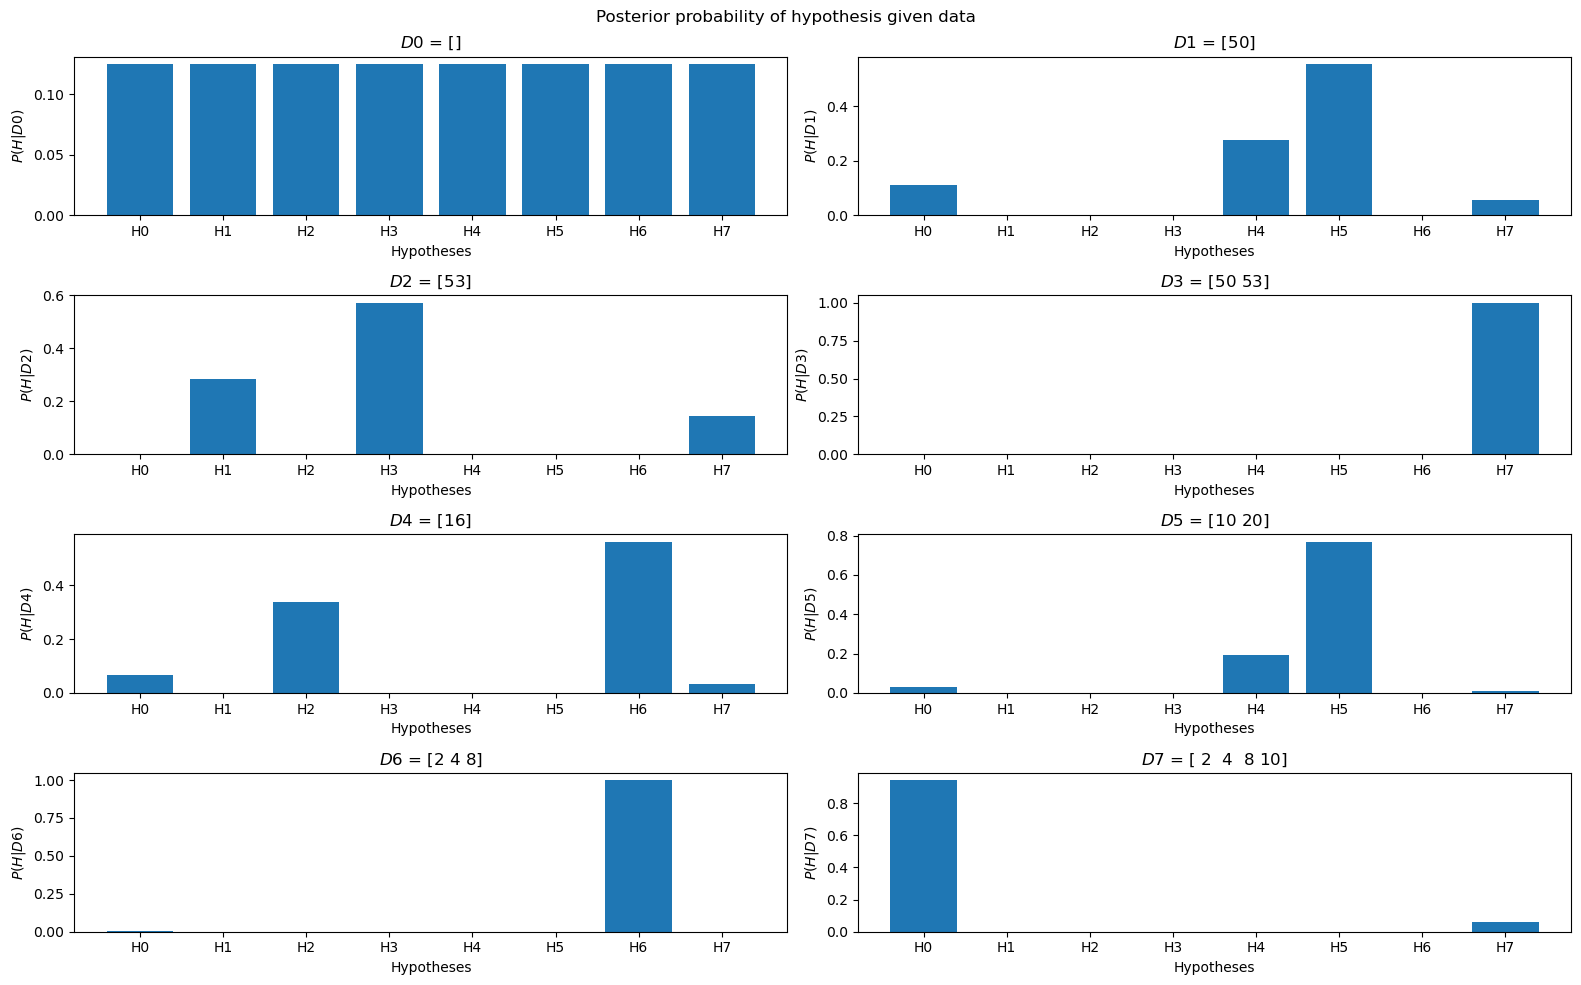

In [25]:
# YOUR CODE HERE
figure, axis = plt.subplots(nrows=4, ncols=2, figsize=(16,10))

for i, ax in enumerate(figure.axes):
    posterior = compute_posterior(DataSets[i], H, np.ones(8)/8)
    ax.bar(np.arange(8), posterior)
    ax.set_xticks(np.arange(8),['H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7'])
    ax.set_title(f"$D{i}$ = {DataSets[i]}")
    ax.set_xlabel("Hypotheses")
    ax.set_ylabel(f"$P(H|D{i})$")
        
    
figure.suptitle("Posterior probability of hypothesis given data")
figure.tight_layout()

figure.savefig("PS4_Q11.png")

## Q12 - Posterior predictive [5 pts, HELP]

_"Yesterday's posterior is today's prior."_ Once you've updated your prior probabilities based on data, you can use the new posterior probabilities to make predictions for new data, which we call "[posterior predictives](https://en.wikipedia.org/wiki/Posterior_predictive_distribution)". Since we don't know which hypothesis is true, the posterior predictive probability should be marginalized over all hypotheses ($D$: observed data; $\tilde {d}$: new data; hypothesis: $h \in H$): 

$${\displaystyle p({\tilde {d}}|\mathbf {D} )= \sum_{h\in H} p({\tilde {d}}|h ,\mathbf {D} )\,p(h |\mathbf {D})}.$$

Write a function called `posterior_predictive` that returns the posterior predictive probability of each number from 1 to 100 marginalized over 8 hypotheses. Your function should take 4 inputs &mdash; numbers from 1 to 100 (a NumPy array), a dataset (a NumPy array), a set of hypotheses (a list), priors over the hypotheses (a NumPy array) &mdash; and return an array containing each number's posterior predictive probability. You'll be working with the same 8 datasets from Q11.

In 8 subplots (1 per dataset), plot the posterior predictive probability (marginalizing over all hypotheses) for each number from 1 to 100 &mdash; that is, the predicted probability that each number will be accepted by the true hypothesis, which is unknown (hence the marginalization). You **MUST** follow the plotting instructions below to get full credit:

- Use (16, 10) as your global figure size (`figsize=(16, 10)`)
- Arrange 8 subplots in a 4 (rows) $\times$ 2 (columns) grid
- Title each subplot using the corresponding dataset label (i.e., "D1", "D2", etc.)
- Label all x- and y-axes in the subplots and title your global figure
- Use `[0, .2]` as the y-axis limit in each subplot
- Use `axes[i].bar()` instead of `axes[i].plot()`
- Your x-axis should be the numbers between 1 and 100 and your y-axis is the probability you computed

> **Tip**: add `plt.tight_layout()` in the end before saving your plot to avoid overlapping between subplots.


Finally, upload your figure in Gradescope as `PS4_Q12.png`.

In [26]:
def posterior_predictive(data, hyp, priors, new=np.arange(1,101)):
    predictions = []
    posteriors = compute_posterior(data, hyp, priors)
    
    for d in new:
        prediction = 0
        for p, h in zip(posteriors, hyp):
            arr, like = compute_likelihood(h, np.array([d]))
            prediction += like * p
        predictions.append(prediction)
        
    return predictions

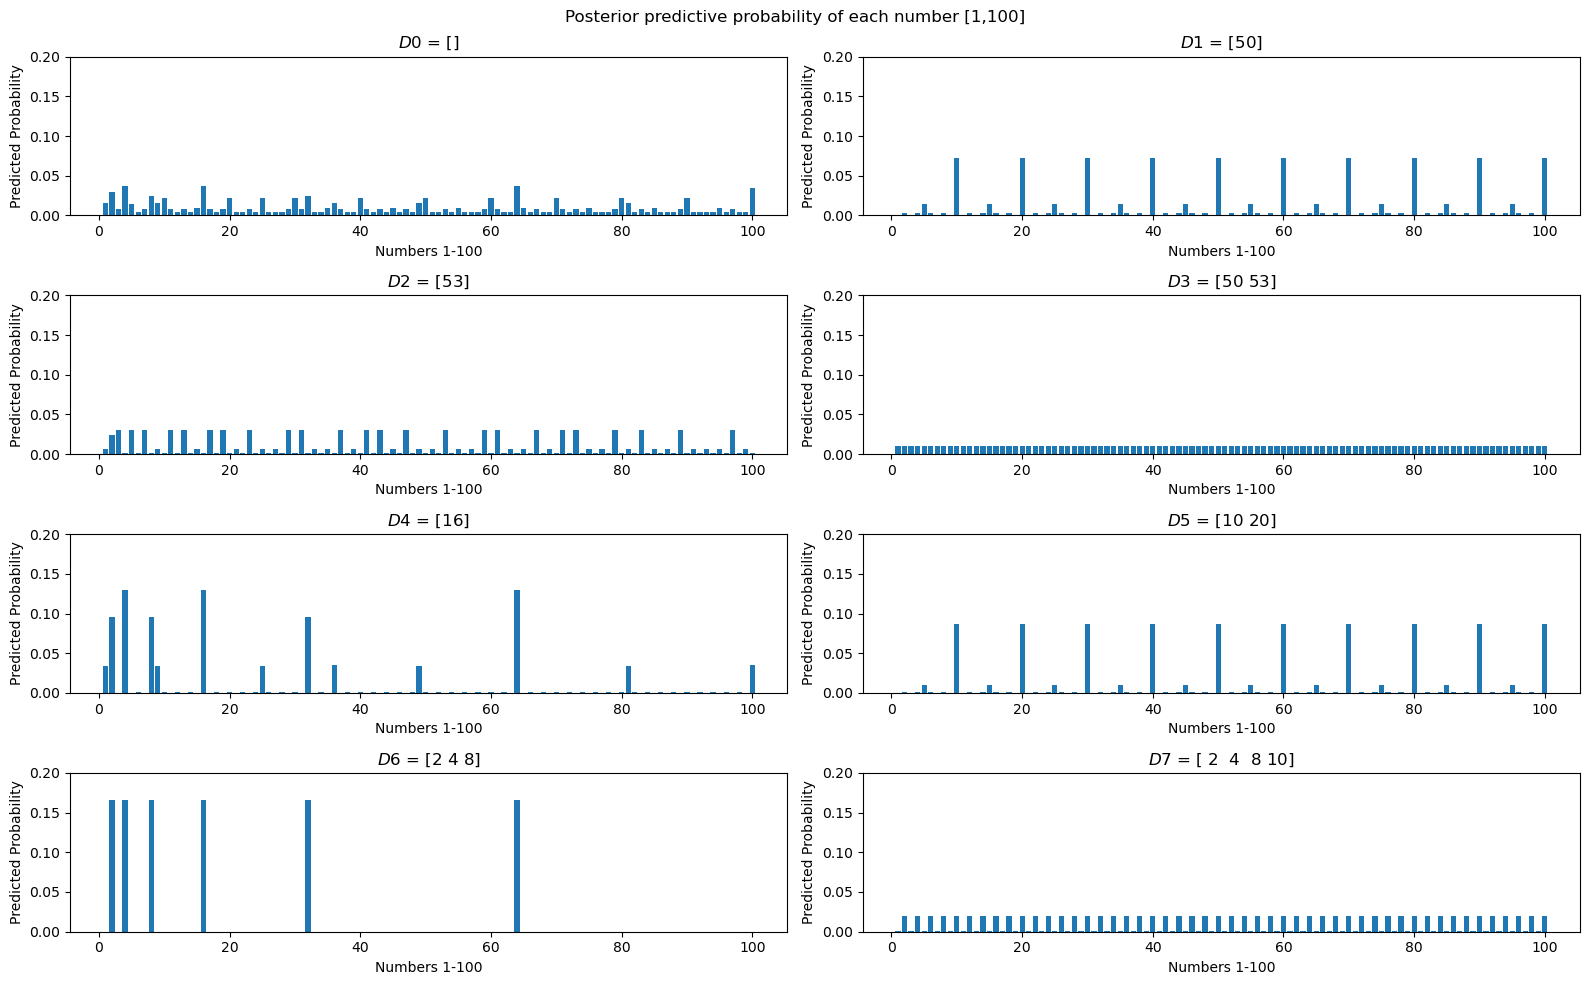

In [27]:
# YOUR CODE HERE
figure, axis = plt.subplots(nrows=4, ncols=2, figsize=(16,10))

for i, ax in enumerate(figure.axes):
    pred = posterior_predictive(DataSets[i], H, np.ones(8)/8)
    ax.bar(np.arange(1,101), pred)
    ax.set_title(f"$D{i}$ = {DataSets[i]}")
    ax.set_xlabel("Numbers 1-100")
    ax.set_ylabel("Predicted Probability")
    ax.set_ylim([0,0.2])
        
    
figure.suptitle("Posterior predictive probability of each number [1,100]")
figure.tight_layout()

figure.savefig("PS4_Q12.png")

## Q13.1 - Testing other hypotheses [2 pts, SOLO]

In this question, you will re-make the plots from Q12 but now incorporate "range-based hypotheses". 

To do this, let's assume that the 8 hypotheses H0-H7 each have a prior of 1/9 and the remaining 1/9th of the total probability is distributed equally among all intervals in the range 1-100. Here we will define an "interval" as something containing two distinct points, such as [50-51] or [3-88] (first number is smaller than the second), but not [31]. To calculate each number's likelihood within each interval, keep on using the size principle prior.

> **Tip**: you can use `permutations` from `itertools` to get all permutations of 1-100 of length 2 (but then you only need to keep pairs where the first number is smaller than the second)

How many range-based hypotheses are there? (There are a lot!) Enter your answer (numerical value) in Gradescope.

In [28]:
#YOUR CODE HERE

from itertools import permutations

perm = list(permutations(np.arange(1,101), 2))
intervals = []

for interval in perm:
    if interval[0] < interval[1]:
        intervals.append(interval)

rgh = []

for interval in intervals:
    rgh.append(np.arange(interval[0], interval[1]+1))

new_H = H + rgh

new_priors = np.append(np.ones(8)/9,np.ones(4950)/4950/9)

## Q13.2 - Testing other hypotheses [8 pts, SOLO]
A. Re-plot Q12 (check the instructions above) but with new range-based hypotheses taken into account. Upload your new figure as `PS4_Q13.png` in Gradescope.

B. For each subplot, write a sentence to comment on whether including range-based hypotheses makes it better match your own intuitions about how people generalize rules from observed data and explain why you think so.

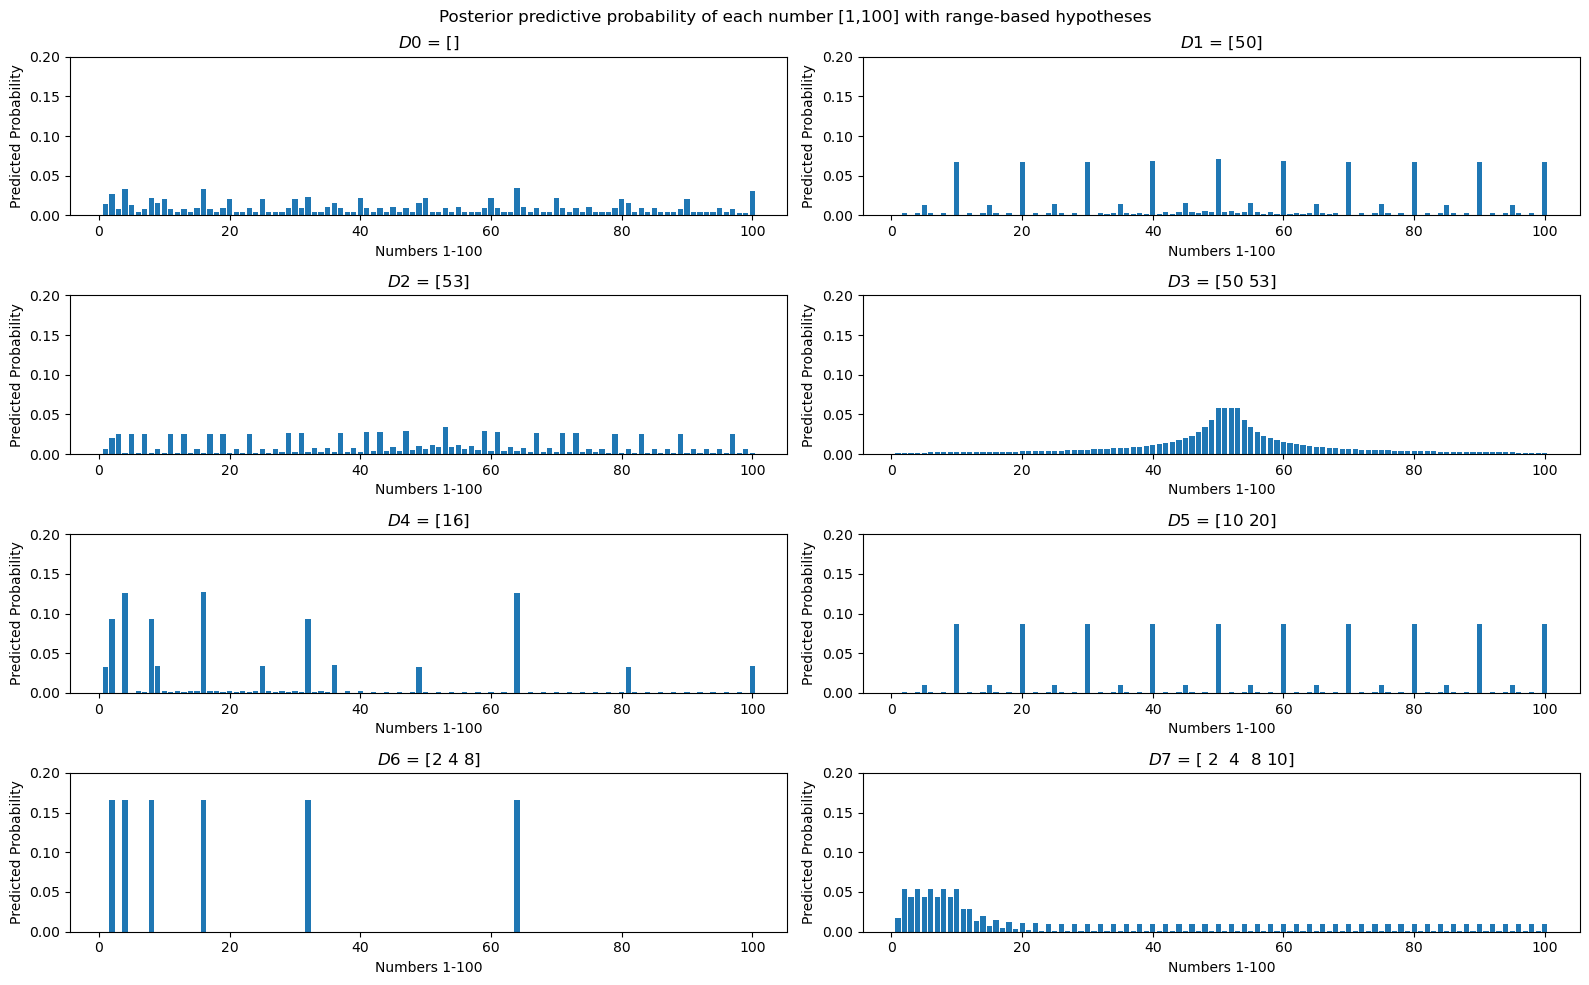

In [29]:
# YOUR CODE HERE
figure, axis = plt.subplots(nrows=4, ncols=2, figsize=(16,10))

for i, ax in enumerate(figure.axes):
    pred = posterior_predictive(DataSets[i], new_H, new_priors)
    ax.bar(np.arange(1,101), pred)
    ax.set_title(f"$D{i}$ = {DataSets[i]}")
    ax.set_xlabel("Numbers 1-100")
    ax.set_ylabel("Predicted Probability")
    ax.set_ylim([0,0.2])
        
    
figure.suptitle("Posterior predictive probability of each number [1,100] with range-based hypotheses")
figure.tight_layout()

figure.savefig("PS4_Q13.png")

<div style="background-color: #c1f2a5">

# Submission

    
When you're done with your problem set, do the following:
- Upload your answers in Gradescope's PS4.
- Convert your Jupyter Notebook into a `.py` file by doing so:    
    
</div>


<center>    
  <img src="../img/py_exporting_instructions.png" width="500"/>
</center>

<div style="background-color: #c1f2a5">
    
- Submit the `.py` file you just created in Gradescope's PS4-code.
    
</div>        




</div>


---